# ДЗ №5 Гладышев В.В.

## Задание № 1 - 3

Прочитайте базу my_BRENT2019.csv и перейдите к представлению ряда первыми разностями

сделайте ее перрасчет (ресемплинг) в представление по неделям.

Добавьте первые разности по стоимости доллара и евро к рублю

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns


from sklearn.metrics import mean_squared_error
import os


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
path_brent = 'my_BRENT2019.csv'
brent_data = pd.read_csv(path_brent,sep = ',', index_col=[0], parse_dates=[0])
brent_data.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-01,76.37,2010,9,1,3,244,35,2,0,0,0
2010-09-02,76.89,2010,9,2,3,245,35,3,0,0,0
2010-09-03,76.57,2010,9,3,3,246,35,4,0,0,0
2010-09-04,76.62,2010,9,4,3,247,35,5,0,0,0
2010-09-05,76.63,2010,9,5,3,248,35,6,0,1,0


In [3]:
brent_data_w = brent_data.resample('W').mean()

In [4]:
brent_data_w[brent_data_w['Значение'].isnull()].index

DatetimeIndex(['2011-10-16'], dtype='datetime64[ns]', name='Дата', freq='W-SUN')

In [5]:
brent_data_w.dropna(inplace = True)

In [6]:
brent_data_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 469 entries, 2010-09-05 to 2019-09-01
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         469 non-null    float64
 1   year             469 non-null    float64
 2   month            469 non-null    float64
 3   dayofmonth       469 non-null    float64
 4   quarter          469 non-null    float64
 5   dayofyear        469 non-null    float64
 6   weekofyear       469 non-null    float64
 7   dayofweek        469 non-null    float64
 8   is_holiday       469 non-null    float64
 9   is_prev_holiday  469 non-null    float64
 10  is_next_holiday  469 non-null    float64
dtypes: float64(11)
memory usage: 44.0 KB


In [7]:
brent_data_w.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday
Дата,,,,,,,,,,,
2010-09-05,76.616000,2010.0,9.000000,3.000000,3.000000,246.000000,35.0,4.000000,0.000000,0.2,0.000000
2010-09-12,77.673333,2010.0,9.000000,8.500000,3.000000,251.500000,36.0,2.500000,0.166667,0.0,0.166667
2010-09-19,78.693333,2010.0,9.000000,15.666667,3.000000,258.666667,37.0,2.666667,0.000000,0.0,0.000000
2010-09-26,78.518333,2010.0,9.000000,22.666667,3.000000,265.666667,38.0,2.666667,0.000000,0.0,0.000000
2010-10-03,81.211667,2010.0,9.333333,19.666667,3.333333,272.666667,39.0,2.666667,0.000000,0.0,0.000000


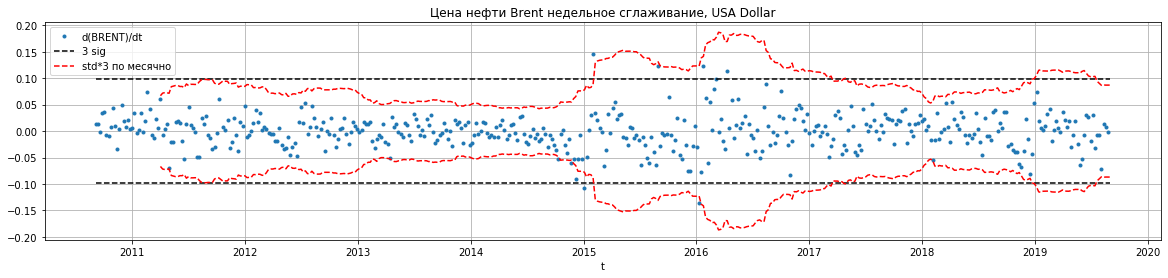

In [8]:
d_brent_data1 = (brent_data_w['Значение'].values[1:] - brent_data_w['Значение'].values[:-1])/brent_data_w['Значение'].values[:-1]
std_d_brent = pd.DataFrame(data=d_brent_data1,index =brent_data_w.index[1:] ).rolling(30).std()
s_brent1 = np.std(d_brent_data1)*3 
plt.figure(figsize=(20,4))
plt.plot(brent_data_w.iloc[:-1].index,d_brent_data1,'.', label='d(BRENT)/dt')
plt.plot(brent_data_w.iloc[[0,-1]].index,[s_brent1, s_brent1],'--k',label ='3 sig')
plt.plot(brent_data_w.iloc[[0,-1]].index,[-s_brent1, -s_brent1],'--k')
plt.plot(std_d_brent.index,std_d_brent*3,'--r',label = 'std*3 по месячно')
plt.plot(std_d_brent.index,-std_d_brent*3,'--r')
plt.xlabel('t')
plt.legend()
plt.grid()
plt.title('Цена нефти Brent недельное сглаживание, USA Dollar')
plt.show()

ind_anomal_brent1 = np.where( abs(d_brent_data1)>s_brent1)[0]
ind_anomal_brent2 = np.where( abs(d_brent_data1)>std_d_brent.values)[0]

__На динамику ряда Brent оказывают влияние внешние факторы. Для построения модели будем использовать данные начиная со второго квартала 2017 года__

In [9]:
brent_data_w_c = brent_data_w.loc['2017-04-01':,:]

In [10]:
p =3

#добавляем историю длиной р
for i in range(p):
    brent_data_w_c['t'+str(p-i+1)]=0.0
    brent_data_w_c['t'+str(p-i+1)].values[p+2:] = brent_data_w_c['Значение'].values[i+1:-(p-i+1)]
for i in range(p):
    brent_data_w_c['d'+str(p-i+1)]=0.0    
    brent_data_w_c['d'+str(p-i+1)].values[i+1:] =( (brent_data_w_c['Значение'].values[i+1:]- brent_data_w_c['Значение'].values[i:-1]))

In [11]:
brent_data_w_c.head()

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2
Дата,,,,,,,,,,,,,,,,,
2017-04-02,52.513333,2017.0,3.166667,24.500000,1.166667,88.666667,13.0,2.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2017-04-09,54.491667,2017.0,4.000000,5.666667,2.000000,95.666667,14.0,2.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.978333,0.000000,0.000000
2017-04-16,55.844000,2017.0,4.000000,12.400000,2.000000,102.400000,15.0,2.400000,0.0,0.0,0.0,0.0,0.0,0.0,1.352333,1.352333,0.000000
2017-04-23,53.436667,2017.0,4.000000,19.666667,2.000000,109.666667,16.0,2.666667,0.0,0.0,0.0,0.0,0.0,0.0,-2.407333,-2.407333,-2.407333
2017-04-30,51.985000,2017.0,4.000000,26.666667,2.000000,116.666667,17.0,2.666667,0.0,0.0,0.0,0.0,0.0,0.0,-1.451667,-1.451667,-1.451667


In [12]:
brent_data_w_c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2017-04-02 to 2019-09-01
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         127 non-null    float64
 1   year             127 non-null    float64
 2   month            127 non-null    float64
 3   dayofmonth       127 non-null    float64
 4   quarter          127 non-null    float64
 5   dayofyear        127 non-null    float64
 6   weekofyear       127 non-null    float64
 7   dayofweek        127 non-null    float64
 8   is_holiday       127 non-null    float64
 9   is_prev_holiday  127 non-null    float64
 10  is_next_holiday  127 non-null    float64
 11  t4               127 non-null    float64
 12  t3               127 non-null    float64
 13  t2               127 non-null    float64
 14  d4               127 non-null    float64
 15  d3               127 non-null    float64
 16  d2               127 non-null    float64
dt

In [13]:
rub_doll=pd.read_excel('RC_F01_09_2010_T01_09_2019.xlsx')
rub_doll.index = pd.to_datetime(rub_doll['data'].values)
rub_doll.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_doll.head()

,curs
2010-09-01,30.8669
2010-09-02,30.8001
2010-09-03,30.6858
2010-09-04,30.6922
2010-09-07,30.5771


In [14]:
rub_doll_w = rub_doll.resample('W').mean()

In [15]:
rub_doll_w_c = rub_doll_w.loc['2017-04-01':,:]
rub_doll_w_c.head()

,curs
2017-04-02,56.66446
2017-04-09,56.38918
2017-04-16,56.79936
2017-04-23,56.21046
2017-04-30,56.43846


In [16]:
rub_e=pd.read_excel('R_E01_09_2010_T01_09_2019.xlsx')
rub_e.index = pd.to_datetime(rub_e['data'].values)
rub_e.drop(['nominal','cdx','data'], axis=1,inplace = True)
rub_e.head()

,curs
2010-09-01,39.0127
2010-09-02,39.1654
2010-09-03,39.2901
2010-09-04,39.3505
2010-09-07,39.4720


In [17]:
rub_e_w = rub_e.resample('W').mean()

In [18]:
rub_e_w_c = rub_e_w.loc['2017-04-01':,:]
rub_e_w_c.head()

,curs
2017-04-02,61.14242
2017-04-09,60.09684
2017-04-16,60.27600
2017-04-23,60.12984
2017-04-30,61.47098


In [19]:
rub_doll_w_c[rub_doll_w_c['curs'].isnull()].index

DatetimeIndex(['2018-01-07', '2019-01-06'], dtype='datetime64[ns]', freq='52W-SUN')

In [20]:
rub_e_w_c[rub_e_w_c['curs'].isnull()].index

DatetimeIndex(['2018-01-07', '2019-01-06'], dtype='datetime64[ns]', freq='52W-SUN')

In [21]:
brent_data_w_c.loc[rub_e_w_c[rub_e_w_c['curs'].isnull()].index]

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,is_next_holiday,t4,t3,t2,d4,d3,d2
2018-01-07,67.578,2018.0,1.0,4.2,1.0,4.2,1.0,3.2,0.0,0.0,0.2,62.546667,63.388333,64.384000,1.208,1.208,1.208
2019-01-06,55.916,2018.8,3.2,9.2,1.6,76.0,1.0,3.0,0.0,0.2,0.2,61.388333,60.451667,55.521667,2.838,2.838,2.838


In [22]:
brent_data_w_c.drop(brent_data_w_c.loc[rub_e_w_c[rub_e_w_c['curs'].isnull()].index].index, axis=0, inplace=True)

In [23]:
brent_data_w_c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2017-04-02 to 2019-09-01
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         125 non-null    float64
 1   year             125 non-null    float64
 2   month            125 non-null    float64
 3   dayofmonth       125 non-null    float64
 4   quarter          125 non-null    float64
 5   dayofyear        125 non-null    float64
 6   weekofyear       125 non-null    float64
 7   dayofweek        125 non-null    float64
 8   is_holiday       125 non-null    float64
 9   is_prev_holiday  125 non-null    float64
 10  is_next_holiday  125 non-null    float64
 11  t4               125 non-null    float64
 12  t3               125 non-null    float64
 13  t2               125 non-null    float64
 14  d4               125 non-null    float64
 15  d3               125 non-null    float64
 16  d2               125 non-null    float64
dt

In [24]:
rub_doll_w_c.dropna(inplace = True)
rub_e_w_c.dropna(inplace = True)

In [25]:
rub_doll_w_c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2017-04-02 to 2019-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   curs    125 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


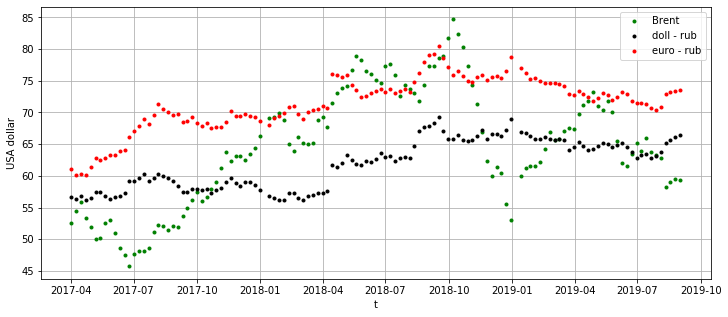

In [26]:
plt.figure(figsize=(12,5))
plt.plot(brent_data_w_c.index, brent_data_w_c['Значение'].values,'.g', label='Brent ')
plt.plot(rub_doll_w_c.index ,rub_doll_w_c['curs'].values,'.k', label='doll - rub')
plt.plot(rub_e_w_c.index, rub_e_w_c['curs'].values,'.r', label='euro - rub')
plt.ylabel('USA dollar')
plt.xlabel('t')
plt.grid()
plt.legend()
plt.show()

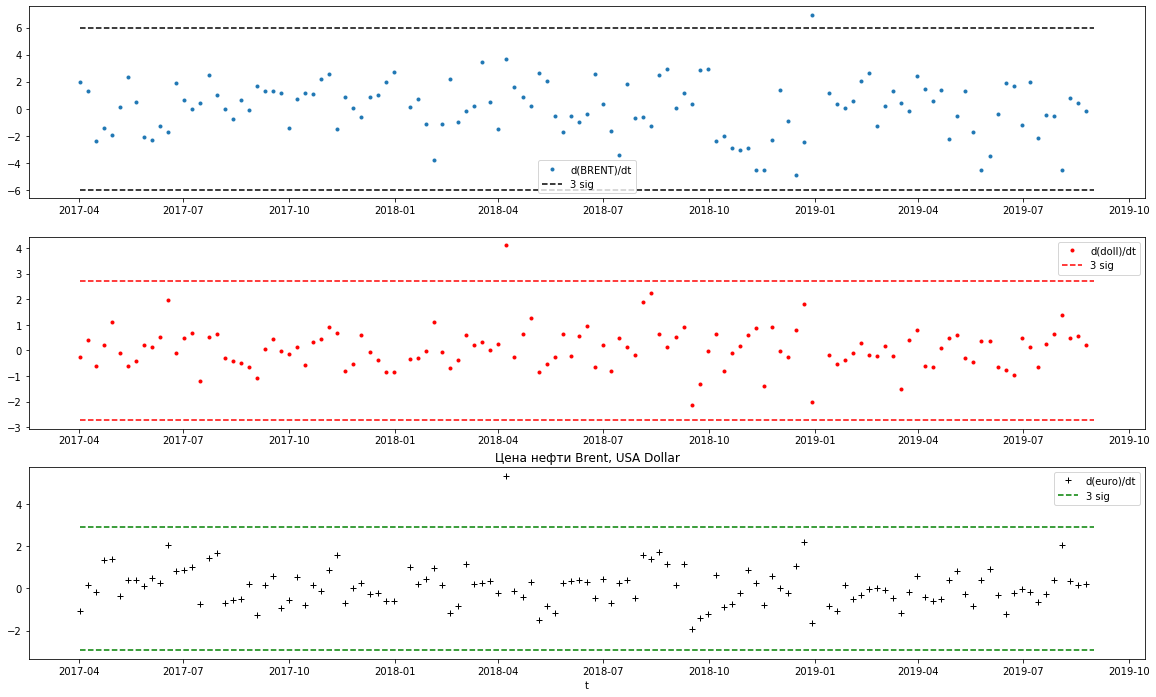

In [27]:
d_brent_data = brent_data_w_c['Значение'].values[1:]- brent_data_w_c['Значение'].values[:-1]
s_brent = np.std(d_brent_data) *3

d_rub_doll = rub_doll_w_c['curs'].values[1:]- rub_doll_w_c['curs'].values[:-1]
s_rub = np.std(d_rub_doll)**0.5 *3

d_rub_e = rub_e_w_c['curs'].values[1:]- rub_e_w_c['curs'].values[:-1]
s_rube = np.std(d_rub_e)**0.5 *3

plt.figure(figsize=(20,12))
plt.subplot(3,1,1)
plt.plot(brent_data_w_c.iloc[:-1].index,d_brent_data,'.', label='d(BRENT)/dt')
plt.plot(brent_data_w_c.iloc[[0,-1]].index,[s_brent, s_brent],'--k',label ='3 sig')
plt.plot(brent_data_w_c.iloc[[0,-1]].index,[-s_brent, -s_brent],'--k')
plt.legend()

plt.subplot(3,1,2)
plt.plot(rub_doll_w_c.iloc[:-1].index,d_rub_doll,'.r', label='d(doll)/dt')
plt.plot(rub_doll_w_c.iloc[[0,-1]].index,[s_rub, s_rub],'--r',label ='3 sig')
plt.plot(rub_doll_w_c.iloc[[0,-1]].index,[-s_rub, -s_rub],'--r')
plt.legend()

plt.subplot(3,1,3)
plt.plot(rub_e_w_c.iloc[:-1].index,d_rub_e,'+k', label='d(euro)/dt')
plt.plot(rub_e_w_c.iloc[[0,-1]].index,[s_rube, s_rube],'--g',label ='3 sig')
plt.plot(rub_e_w_c.iloc[[0,-1]].index,[-s_rube, -s_rube],'--g')

plt.xlabel('t')
plt.legend()
plt.title('Цена нефти Brent, USA Dollar')
plt.show()

In [28]:
brent_data_w_c['brent_dt']=0.0
brent_data_w_c['doll_dt']=0.0
brent_data_w_c['euro_dt']=0.0

In [29]:
brent_data_w_c['brent_dt'].values[1:] = d_brent_data
brent_data_w_c['doll_dt'].values[1:] = d_rub_doll
brent_data_w_c['euro_dt'].values[1:] = d_rub_e

In [30]:
brent_data_w_c['doll']=0.0
brent_data_w_c['doll'].values[:] = rub_doll_w_c['curs'].values[:]

In [31]:
brent_data_w_c['euro']=0.0
brent_data_w_c['euro'].values[:] = rub_e_w_c['curs'].values[:]

In [32]:
p =3

#добавляем историю длиной р
for i in range(p):
    brent_data_w_c['doll_t'+str(p-i+1)]=0.0
    brent_data_w_c['doll_t'+str(p-i+1)].values[p+2:] = brent_data_w_c['doll'].values[i+1:-(p-i+1)]
    brent_data_w_c['euro_t'+str(p-i+1)]=0.0
    brent_data_w_c['euro_t'+str(p-i+1)].values[p+2:] = brent_data_w_c['euro'].values[i+1:-(p-i+1)]

In [33]:
brent_data_w_c.head(6)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,...,doll_dt,euro_dt,doll,euro,doll_t4,euro_t4,doll_t3,euro_t3,doll_t2,euro_t2
Дата,,,,,,,,,,,,,,,,,,,,,
2017-04-02,52.513333,2017.0,3.166667,24.500000,1.166667,88.666667,13.0,2.666667,0.0,0.0,...,0.000000,0.000000,56.664460,61.142420,0.00000,0.00000,0.00000,0.000,0.00000,0.00000
2017-04-09,54.491667,2017.0,4.000000,5.666667,2.000000,95.666667,14.0,2.666667,0.0,0.0,...,-0.275280,-1.045580,56.389180,60.096840,0.00000,0.00000,0.00000,0.000,0.00000,0.00000
2017-04-16,55.844000,2017.0,4.000000,12.400000,2.000000,102.400000,15.0,2.400000,0.0,0.0,...,0.410180,0.179160,56.799360,60.276000,0.00000,0.00000,0.00000,0.000,0.00000,0.00000
2017-04-23,53.436667,2017.0,4.000000,19.666667,2.000000,109.666667,16.0,2.666667,0.0,0.0,...,-0.588900,-0.146160,56.210460,60.129840,0.00000,0.00000,0.00000,0.000,0.00000,0.00000
2017-04-30,51.985000,2017.0,4.000000,26.666667,2.000000,116.666667,17.0,2.666667,0.0,0.0,...,0.228000,1.341140,56.438460,61.470980,0.00000,0.00000,0.00000,0.000,0.00000,0.00000
2017-05-07,50.080000,2017.0,5.000000,3.666667,2.000000,123.666667,18.0,2.666667,0.0,0.0,...,1.100065,1.389895,57.538525,62.860875,56.38918,60.09684,56.79936,60.276,56.21046,60.12984


In [34]:
brent_data_w_c.drop(brent_data_w_c.loc[:'2017-04-30'].index, axis=0, inplace=True)

In [35]:
brent_data_w_c.head(6)

,Значение,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,is_holiday,is_prev_holiday,...,doll_dt,euro_dt,doll,euro,doll_t4,euro_t4,doll_t3,euro_t3,doll_t2,euro_t2
Дата,,,,,,,,,,,,,,,,,,,,,
2017-05-07,50.080000,2017.0,5.0,3.666667,2.0,123.666667,18.0,2.666667,0.000000,0.000000,...,1.100065,1.389895,57.538525,62.860875,56.389180,60.096840,56.799360,60.276000,56.210460,60.129840
2017-05-14,50.193333,2017.0,5.0,10.666667,2.0,130.666667,19.0,2.666667,0.000000,0.000000,...,-0.084358,-0.356075,57.454167,62.504800,56.799360,60.276000,56.210460,60.129840,56.438460,61.470980
2017-05-21,52.571667,2017.0,5.0,17.666667,2.0,137.666667,20.0,2.666667,0.000000,0.000000,...,-0.623587,0.392100,56.830580,62.896900,56.210460,60.129840,56.438460,61.470980,57.538525,62.860875
2017-05-28,53.100000,2017.0,5.0,24.666667,2.0,144.666667,21.0,2.666667,0.000000,0.166667,...,-0.399700,0.381300,56.430880,63.278200,56.438460,61.470980,57.538525,62.860875,57.454167,62.504800
2017-06-04,51.005000,2017.0,5.5,16.166667,2.0,151.666667,22.0,2.666667,0.166667,0.000000,...,0.197100,0.095340,56.627980,63.373540,57.538525,62.860875,57.454167,62.504800,56.830580,62.896900
2017-06-11,48.691667,2017.0,6.0,7.666667,2.0,158.666667,23.0,2.666667,0.000000,0.000000,...,0.145100,0.475380,56.773080,63.848920,57.454167,62.504800,56.830580,62.896900,56.430880,63.278200


In [36]:
brent_data_w_c.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 120 entries, 2017-05-07 to 2019-09-01
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Значение         120 non-null    float64
 1   year             120 non-null    float64
 2   month            120 non-null    float64
 3   dayofmonth       120 non-null    float64
 4   quarter          120 non-null    float64
 5   dayofyear        120 non-null    float64
 6   weekofyear       120 non-null    float64
 7   dayofweek        120 non-null    float64
 8   is_holiday       120 non-null    float64
 9   is_prev_holiday  120 non-null    float64
 10  is_next_holiday  120 non-null    float64
 11  t4               120 non-null    float64
 12  t3               120 non-null    float64
 13  t2               120 non-null    float64
 14  d4               120 non-null    float64
 15  d3               120 non-null    float64
 16  d2               120 non-null    float64
 1

## Задание № 4

Постройте модель предсказания 1-й точки от текущей (h=1).

In [37]:
#импорт модулей для формирования модели
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

In [38]:
import itertools

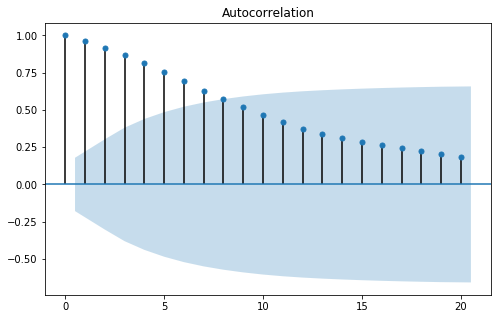

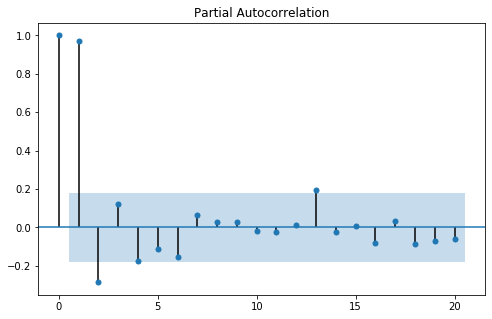

In [39]:
with plt.rc_context():
    plt.rc("figure", figsize=(8, 5))
    sm.graphics.tsa.plot_acf(brent_data_w_c['Значение'].values, lags=20)
    sm.graphics.tsa.plot_pacf(brent_data_w_c['Значение'].values, lags=20)
    plt.show()

__Цикличности нет. Есть большая зависимость от предыдущего (дифференциальная составляющая)__

### Пробуем ARIMA

__p = 1, q = 9__

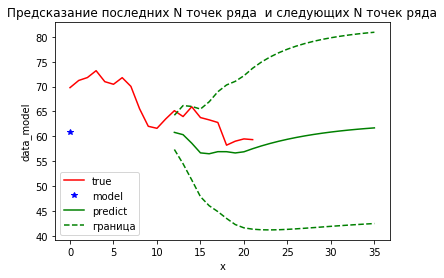

In [40]:
N = 12

# строим модель
model = ARIMA(brent_data_w_c['Значение'].values[:-N], order=(1, 0, 9))
model_fit = model.fit(disp=False)
# делаем оценку старых значений
y_p = model_fit.predict(len(brent_data_w_c['Значение'].values[:-N]), len(brent_data_w_c['Значение'].values[:-N]), typ='levels')
y_f = model_fit.forecast(2*N)
plt.plot(brent_data_w_c['Значение'].values[-10-N:],'r',label ='true')
plt.plot(y_p,'*b',label ='model')
plt.plot(np.arange(2*N)+N,y_f[0],'g',label ='predict')
plt.plot(np.arange(2*N)+N,y_f[2][:,1],'--g', label = 'граница')
plt.plot(np.arange(2*N)+N,y_f[2][:,0],'--g')
plt.xlabel('x')
plt.ylabel('data_model')
plt.title('Предсказание последних N точек ряда  и следующих N точек ряда')
plt.legend()
plt.show()

In [41]:
# Определим d и q в диапазоне 0-3
d = p = range(0, 3)
q = range(7, 10)
# зададим сетку p, d, q
pdq = list(itertools.product(p, d, q))

In [42]:
warnings.filterwarnings("ignore") # отключает предупреждения
for param in pdq:
    try:
        mod_b = sm.tsa.statespace.SARIMAX(brent_data_w_c['Значение'].values,
                                          order = param,
                                          seasonal_order = [0, 0, 0, 0],
                                          trend = 'ct',
                                          enforce_stationarity = False,
                                          enforce_invertibility = False)
        results = mod_b.fit()
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

ARIMA(0, 0, 7) - AIC:491.55315761716093
ARIMA(0, 0, 8) - AIC:491.50008919617215
ARIMA(0, 0, 9) - AIC:485.89088926785996
ARIMA(0, 1, 7) - AIC:467.9189590658892
ARIMA(0, 1, 8) - AIC:464.65199482359793
ARIMA(0, 1, 9) - AIC:464.64410666147995
ARIMA(0, 2, 7) - AIC:472.90908335748907
ARIMA(0, 2, 8) - AIC:470.587382085847
ARIMA(0, 2, 9) - AIC:470.9879647701521
ARIMA(1, 0, 7) - AIC:470.230179210406
ARIMA(1, 0, 8) - AIC:469.47834227516785
ARIMA(1, 0, 9) - AIC:466.6583125571749
ARIMA(1, 1, 7) - AIC:466.55266688655394
ARIMA(1, 1, 8) - AIC:466.08999392759665
ARIMA(1, 1, 9) - AIC:465.150652625514
ARIMA(1, 2, 7) - AIC:473.8781399897575
ARIMA(1, 2, 8) - AIC:471.4850094196651
ARIMA(1, 2, 9) - AIC:472.97662308921014
ARIMA(2, 0, 7) - AIC:472.2063738295652
ARIMA(2, 0, 8) - AIC:470.4278490402655
ARIMA(2, 0, 9) - AIC:468.7820510726476
ARIMA(2, 1, 7) - AIC:469.65804186742423
ARIMA(2, 1, 8) - AIC:469.868924331211
ARIMA(2, 1, 9) - AIC:467.00892619122703
ARIMA(2, 2, 7) - AIC:473.80827732194257
ARIMA(2, 2, 8) -

Лучшие результаты на недельных данных параметры модели ARIMA(0, 1, 9) - AIC:464.64410666147995

In [43]:
warnings.filterwarnings("ignore") # отключает предупреждения
N = 12  # число точек для теста
nforecast = N + 30

mod_w = sm.tsa.statespace.SARIMAX(brent_data_w_c['Значение'].values[0:-N],order=[0,1,9],
                                seasonal_order=[0,0,0,0],
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt_w = mod_w.fit()
print('AIC:{}',results_opt_w.aic)

AIC:{} 411.3612393406677


In [44]:
print(results_opt_w.summary().tables[0], "\n", results_opt_w.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(0, 1, 9)   Log Likelihood                -195.681
Date:                Fri, 19 Jun 2020   AIC                            411.361
Time:                        14:04:22   BIC                            437.108
Sample:                             0   HQIC                           421.772
                                - 108                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4211      0.133      3.170      0.002       0.161       0.681
ma.L2          0.0230      0.111      0.208      0.835      -0.194       0.240
ma.L3          0.1751      0.133      1.313      0.1

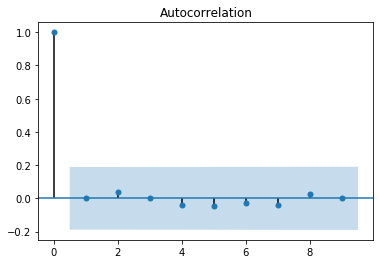

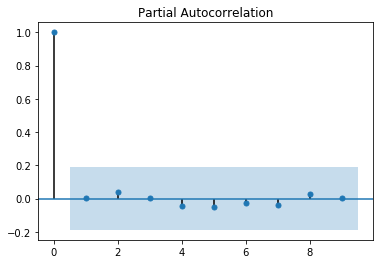

In [45]:
sm.graphics.tsa.plot_acf(results_opt_w.resid, lags=9)
sm.graphics.tsa.plot_pacf(results_opt_w.resid, lags=9)
plt.show()

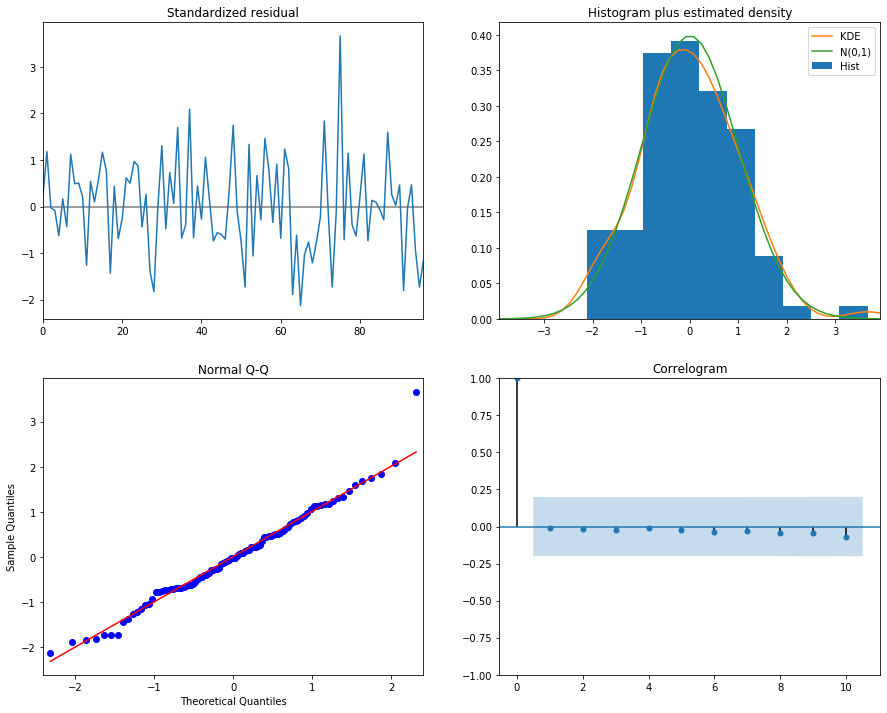

In [46]:
results_opt_w.plot_diagnostics(figsize=(15, 12))
plt.show()

__Параметры модели выглядят неплохо :)__

### Пробуем градиентный бустинг

Горизонт прогнозирования h = 1

In [47]:
from sklearn.preprocessing import StandardScaler

In [48]:
scl_target=StandardScaler() 

h=1
target = brent_data_w_c["Значение"].values[h:].reshape((brent_data_w_c.shape[0]-h,1))
y = scl_target.fit_transform(target)
y.shape

(119, 1)

In [49]:
scl_x=StandardScaler() 

X = brent_data_w_c.iloc[:-h,:].values
X = scl_x.fit_transform(X.astype('float64'))
X.shape

(119, 28)

In [50]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import f_regression, mutual_info_regression

f_test, _ = f_regression(X, y.ravel())

for i in range(X.shape[1]):
    print("F-test={:.2f},  I={}".format(f_test[i],i))

F-test=2336.12,  I=0
F-test=24.96,  I=1
F-test=1.32,  I=2
F-test=0.03,  I=3
F-test=0.83,  I=4
F-test=1.29,  I=5
F-test=1.22,  I=6
F-test=0.63,  I=7
F-test=0.13,  I=8
F-test=0.05,  I=9
F-test=0.07,  I=10
F-test=225.92,  I=11
F-test=327.22,  I=12
F-test=504.29,  I=13
F-test=2.91,  I=14
F-test=2.91,  I=15
F-test=2.91,  I=16
F-test=2.58,  I=17
F-test=0.08,  I=18
F-test=2.66,  I=19
F-test=26.49,  I=20
F-test=88.89,  I=21
F-test=22.88,  I=22
F-test=100.85,  I=23
F-test=25.06,  I=24
F-test=103.37,  I=25
F-test=26.58,  I=26
F-test=101.57,  I=27


In [51]:
sfk =SelectKBest(f_regression, k=8)
X_new1 =sfk.fit_transform(X, y.ravel())
X_new1.shape

(119, 8)

In [52]:
sfp=SelectPercentile(f_regression, percentile=10)
X_new2 = sfp.fit_transform(X, y.ravel())
X_new2.shape

(119, 3)

In [53]:
gr_model = GradientBoostingRegressor(max_depth=5, random_state=10, n_estimators=100).fit(X, y.ravel())
sfm = SelectFromModel(gr_model,  max_features = 8)

sfm.fit(X, y.ravel())
X_new3 = sfm.transform(X)
X_new3.shape

(119, 1)

In [54]:
list_param_k =np.where(sfk.get_support())[0]
list_param_p =np.where(sfp.get_support())[0]
list_param_m =np.where(sfm.get_support())[0]

print('Номера признаков k лучших признаков : ',list_param_k)
print('Номера признаков лучших признаков по процентной форме: ',list_param_p)
print('Номера признаков для выбора по модели : ',list_param_m)

Номера признаков k лучших признаков :  [ 0 11 12 13 21 23 25 27]
Номера признаков лучших признаков по процентной форме:  [ 0 12 13]
Номера признаков для выбора по модели :  [0]


In [55]:
X_new = X[:,[0, 1, 11, 12, 13, 20, 21, 22, 23, 24, 25, 26, 27]]

In [56]:
def split_data( data, split_date ):
    return data.iloc[:split_date,:].copy(), \
           data.iloc[split_date:,:].copy()

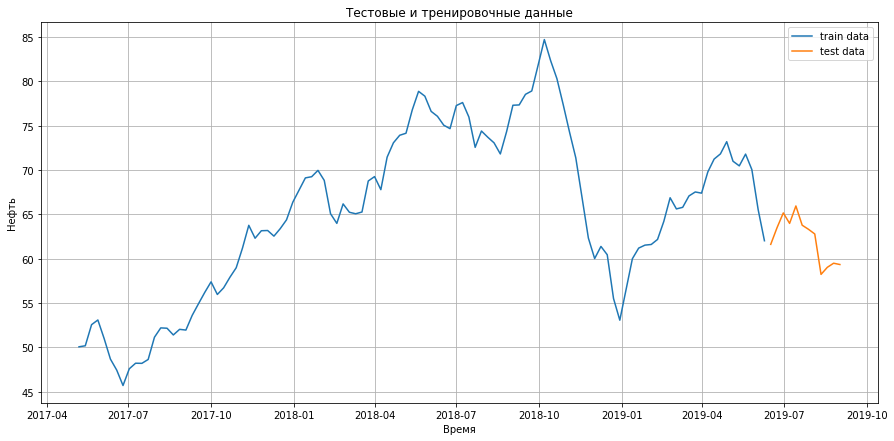

In [57]:
N_split = -12

train, test = split_data( brent_data_w_c[:], N_split)

plt.figure( figsize=( 15, 7 ))
plt.xlabel('Время')
plt.ylabel('Нефть')
plt.plot(train.index,train.iloc[:,0], label='train data' )
plt.plot(test.index,test.iloc[:,0], label='test data')
plt.title( 'Тестовые и тренировочные данные' )
plt.grid()
plt.legend()
plt.show()

In [58]:
X_train = X_new[:N_split,:]
y_train = y[:N_split,0]
X_test = X_new[N_split:,:]
y_test = y[N_split:,0]

In [59]:
model_g = GradientBoostingRegressor(max_depth=5, random_state=10, n_estimators=1000)

In [60]:
model_g.fit( X_train, y_train ) 

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=10, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [61]:
y_pred_g = model_g.predict(X_train)

y_test_pred_g = model_g.predict(X_test)

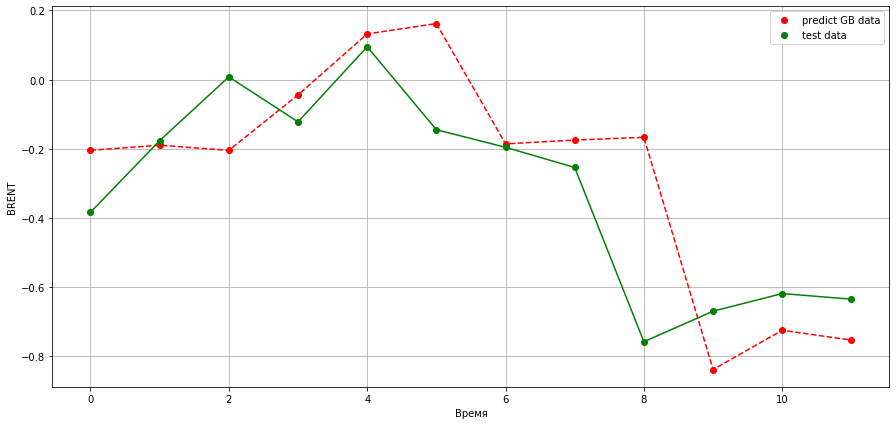

In [62]:
plt.figure( figsize=( 15, 7 ))

plt.xlabel('Время')
plt.ylabel('BRENT')
plt.plot(y_test_pred_g,'or', label='predict GB data' )
plt.plot(y_test_pred_g,'--r' )
plt.plot(y_test, 'og', label='test data')
plt.plot(y_test, '-g')
plt.grid()
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [64]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.049117855634720264 
ошибка mae  :   0.15849492074413363 
оценка R2 :   0.3433523943472835


In [65]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [66]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))

print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   2.349004408724727 %


In [67]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 5, 7, 9], 
              "n_estimators":[500, 700, 900, 1100, 1300]}

#  randomized search
n_iter_search = 10

model_gr =GradientBoostingRegressor()

random_search = RandomizedSearchCV(model_gr, 
                                   scoring = 'neg_mean_absolute_error',
                                   param_distributions=param_dist, 
                                   n_iter=n_iter_search, 
                                   cv=5, 
                                   iid=False, 
                                   random_state=10)

random_search.fit(X_train, y_train)

report(random_search.cv_results_)

Model with rank: 1
Mean validation score: -0.420 (std: 0.188)
Parameters: {'n_estimators': 1100, 'max_depth': 3}

Model with rank: 2
Mean validation score: -0.427 (std: 0.199)
Parameters: {'n_estimators': 900, 'max_depth': 3}

Model with rank: 3
Mean validation score: -0.457 (std: 0.161)
Parameters: {'n_estimators': 500, 'max_depth': 5}



In [68]:
print(random_search.best_params_)

{'n_estimators': 1100, 'max_depth': 3}


In [69]:
model_g_best = GradientBoostingRegressor(max_depth = random_search.best_params_['max_depth'],  
                                         n_estimators = random_search.best_params_['n_estimators'], 
                                         random_state = 10)
model_g_best.fit( X_train, y_train ) 
y_test_pred_g = model_g_best.predict(X_test)

er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   2.7380256184772978 %


In [70]:
er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

ошибка mse :   0.06446105269303941 
ошибка mae  :   0.18806265848497797 
оценка R2 :   0.13823200622754572


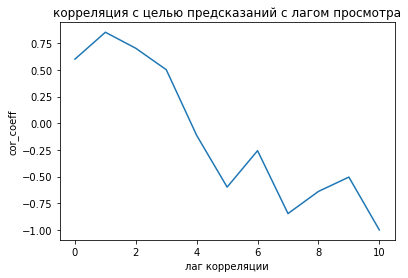

In [71]:
lag=10
p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
for i in range(lag):
    c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
    p_cor.append(c)    

plt.plot(np.array(p_cor) )  
plt.xlabel('лаг корреляции')
plt.ylabel('cor_coeff')
plt.title('корреляция с целью предсказаний с лагом просмотра')
plt.show()

## Задание № 5

Сделайте вывод о поведении ошибки предсказания ряда в сравнении с прямым прогнозированием.

В ряде BRENT очень маленькая глубина корреляции (текущее значение сильно свзано только с несколькими предшествующими). Сглаживание и увеличение дискреты крайне негативно сказываются на качестве прогнозирования